# Long short-term memory

In [93]:
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_data(path):
    full_data = pd.read_excel(path)
    full_data.drop(columns=[1], axis=1, inplace=True)
    return full_data

full_data = read_data("./data/relative_wages_communes.xlsx")
target = full_data[2021]
full_X = full_data.drop(columns=[2021], axis=1)
X_train_all, X_test, y_train_all, y_test = train_test_split(full_X, target, train_size=0.8, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, train_size=0.8, shuffle=True, random_state=42)

In [95]:
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_train = X_train.reshape((-1, 9, 1))
y_train = y_train.reshape((-1, 1))
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
X_val = X_val.reshape((-1, 9, 1))
y_val = y_val.reshape((-1, 1))
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()
X_test = X_test.reshape((-1, 9, 1))
y_test = y_test.reshape((-1, 1))

In [52]:
def get_dataloader(X,y, batch_size, shuffle ):
    # fill your code
    train_x_tensor = torch.tensor(X, dtype=torch.float)
    train_y_tensor = torch.tensor(y, dtype=torch.float)
    train_tensor_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
    dataloader = torch.utils.data.DataLoader(train_tensor_dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle)
    return dataloader

In [53]:
train_dataloader = get_dataloader(X_train, y_train, batch_size = 16, shuffle=True)
val_dataloader = get_dataloader(X_val, y_val, batch_size = y_val.shape[0], shuffle=False)
test_dataloader = get_dataloader(X_test, y_test, batch_size = y_test.shape[0], shuffle=True)

In [60]:
class NeuralNetwork(torch.nn.Module):
    """
    Simple two layer neural network for regression
    """
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                  num_layers=num_layers, batch_first=True)
        self.forecast = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.forecast(out[:, -1, :])
        return out

In [61]:
lstm_model = NeuralNetwork(1, 4, 1)

In [62]:
# -------------------- Training  Step----------------------------
def training_step(model, input_data, optimizer, loss_fn):
    # reset gradients of the optimizer
    optimizer.zero_grad()

    # unfold data
    x_batch, y_batch = input_data

    # get predictions
    y_pred = model(x_batch)

    # calculate loss
    loss = loss_fn(y_pred, y_batch)

    # compute gradients 
    loss.backward()

    # optimise network
    optimizer.step()

    return loss.data.numpy()

In [63]:
def evaluation_step(model, input_data, loss_fn):
    # when we use torch.no_grad pytorch doesn't store information
    # that is required to calculate gradients so is faster
    with torch.no_grad():
        x_batch, y_batch = input_data
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

    return loss.data.numpy()

In [64]:
import time


# -------------------- Train  Loop----------------------------
def train_loop(train_dataloader, val_dataloader, patient, epochs, model, optimizer, loss_fn):
    best_loss = np.inf
    consecutive_epoch = 0
    best_epoch = 0

    train_history = []
    val_history = []
    for epoch in range(epochs): # iterate over epoch    

        # -------------------- Training on each epoch ----------------------------
        total_step = len(train_dataloader)
        accumulated_loss = 0 # monitor loss during training
        start = time.time()
        for step in range(total_step): # iterate over batch
            batch_data = next(iter(train_dataloader)) # get a batch
            loss = training_step(model,batch_data,optimizer,loss_fn) # train model using a single batch
            accumulated_loss = (step * accumulated_loss + loss)/(step+1)
        end = time.time()
        total_time = end - start
        train_history += [{"loss":accumulated_loss, "epoch": epoch, "set":"train"}]

        # -------------------- Monitor Error Validation set ----------------------------
        val_data = next(iter(val_dataloader))
        val_loss = evaluation_step(model, val_data, loss_fn)
        val_history += [{"loss":val_loss, "epoch": epoch, "set":"val"}]
        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{epochs}:({total_time:.3f} sec)  loss:{accumulated_loss:.3f}, val_loss:{val_loss:.3f}")

        # -------------------- Early Stoping ----------------------------
        if val_loss > best_loss:
            consecutive_epoch += 1
        else:
            best_loss = val_loss # we have an improvement
            consecutive_epoch = 0 # reset counter
            best_epoch = epoch
            best_weights = model.state_dict()

        if consecutive_epoch > patient:
            break
    val_history_df = pd.DataFrame(val_history)
    train_history_df = pd.DataFrame(train_history)
    return model, val_history_df, train_history_df, best_loss, best_epoch, best_weights

In [65]:
lr = 0.001


optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

out = train_loop(train_dataloader = train_dataloader,
                 val_dataloader = val_dataloader,
                 patient = 3,
                 epochs = 10,
                 model = lstm_model,
                 optimizer= optimizer,
                 loss_fn= loss_fn)

model, val_history_es_5, train_history_es_5, best_loss, best_epoch, best_weights = out

Epoch 0/10:(0.889 sec)  loss:0.034, val_loss:0.003
Epoch 1/10:(0.718 sec)  loss:0.003, val_loss:0.003
Epoch 2/10:(0.692 sec)  loss:0.002, val_loss:0.002
Epoch 3/10:(0.686 sec)  loss:0.002, val_loss:0.002
Epoch 4/10:(0.706 sec)  loss:0.002, val_loss:0.001
Epoch 5/10:(0.717 sec)  loss:0.001, val_loss:0.001
Epoch 6/10:(0.682 sec)  loss:0.001, val_loss:0.001
Epoch 7/10:(0.683 sec)  loss:0.001, val_loss:0.001
Epoch 8/10:(1.012 sec)  loss:0.001, val_loss:0.001
Epoch 9/10:(0.666 sec)  loss:0.001, val_loss:0.001


In [66]:
test_data = next(iter(test_dataloader))
loss = evaluation_step(lstm_model, test_data, loss_fn)

In [67]:
loss

array(0.00077832, dtype=float32)

In [77]:
def prediction(model, input_data):
    # when we use torch.no_grad pytorch doesn't store information
    # that is required to calculate gradients so is faster
    with torch.no_grad():
        x_batch, y_batch = input_data
        y_pred = model(x_batch)
        
    return y_pred

In [88]:
final_prediction = prediction(lstm_model, test_data)
mean_prediction = final_prediction.mean()
_, target = test_data
mean_target = target.mean()

In [91]:
error = abs(mean_prediction - mean_target)
error

tensor(0.0014)

In [96]:
data_france = read_data("./data/relative_wages_total.xlsx")
y_france = data_france[2021]
X_france = data_france.drop(columns=[2021], axis=1)
X_france, y_france = X_france.to_numpy(), y_france.to_numpy()
X_france = X_france.reshape((-1, 9, 1))
y_france = y_france.reshape((-1, 1))
france_dataloader = get_dataloader(X_france, y_france, batch_size = y_france.shape[0], shuffle=True)
france_data = next(iter(france_dataloader))
france_prediction = prediction(lstm_model, france_data)
_, target_france = france_data
error_france = abs(france_prediction - target_france)
error_france

tensor([[0.0035]])

In [110]:
france_prediction

tensor([[0.8553]])

Prediction for France

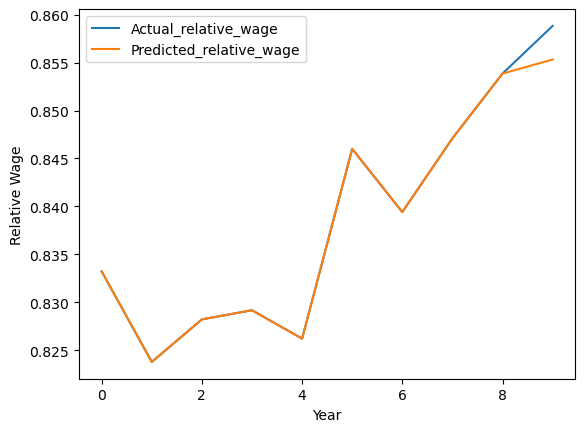

In [132]:
X_correct = data_france.to_numpy()
prediction_2021 = france_prediction.numpy()
X_2020 = X_correct[0, :9]
X_prediction_2021 = np.concatenate((X_2020, prediction_2021[0]))
plt.plot(X_correct[0], label='Actual_relative_wage')
plt.plot(X_prediction_2021, label='Predicted_relative_wage')
plt.xlabel('Year')
plt.ylabel('Relative Wage')
plt.legend()
plt.show()

# Polynomial Regression

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# let's load the data set and let's have a look at it
data = pd.read_excel("./data/relative_wages_communes.xlsx")
data.head()

,1,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,01004,0.788467,0.776413,0.770449,0.791226,0.772972,0.786808,0.780530,0.789157,0.805057,0.798666
1,01007,0.807766,0.797953,0.811816,0.805249,0.807273,0.859143,0.834901,0.841794,0.844538,0.835983
2,01014,0.767019,0.745627,0.714473,0.709948,0.678058,0.671657,0.811562,0.797593,0.782947,0.806123
3,01024,0.823769,0.820816,0.822386,0.814706,0.820175,0.826973,0.815108,0.848995,0.829507,0.836226
4,01025,0.827822,0.842692,0.838516,0.851972,0.849967,0.869575,0.851162,0.854047,0.842680,0.833443


In [135]:
# let's drop the first column (index of the community)
data = data.drop(data.columns[0], axis=1)
data.head()

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.788467,0.776413,0.770449,0.791226,0.772972,0.786808,0.780530,0.789157,0.805057,0.798666
1,0.807766,0.797953,0.811816,0.805249,0.807273,0.859143,0.834901,0.841794,0.844538,0.835983
2,0.767019,0.745627,0.714473,0.709948,0.678058,0.671657,0.811562,0.797593,0.782947,0.806123
3,0.823769,0.820816,0.822386,0.814706,0.820175,0.826973,0.815108,0.848995,0.829507,0.836226
4,0.827822,0.842692,0.838516,0.851972,0.849967,0.869575,0.851162,0.854047,0.842680,0.833443


In [136]:
# let's get the years
years = [int(year) for year in data.keys()]
print(years)

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [137]:
# and let's save the data in a compact way
relative_income = data.values
print(relative_income)
#print(relative_income.shape)

[[0.78846661 0.77641347 0.77044853 ... 0.78915742 0.80505719 0.79866613]
 [0.80776629 0.79795256 0.81181634 ... 0.84179446 0.84453772 0.83598335]
 [0.7670195  0.74562676 0.71447285 ... 0.79759329 0.78294663 0.80612313]
 ...
 [0.899415   0.90860109 0.90913408 ... 0.91241347 0.94322858 0.94369388]
 [0.94613963 0.9296944  0.93069291 ... 0.93792325 0.93928956 0.95113812]
 [0.93039526 0.94104661 0.9198494  ... 0.9362317  0.90780309 0.91089384]]


In [138]:
# let's split the two last years to check how our prediction performs

prediction_year = years[-2:]
#print(prediction_year)
years = years[:-2]
#print(years)
years = np.array(years)
#print(years)
#print(years.shape)

prediction_income = relative_income[:,-2:]
#print(prediction_income)
relative_income = relative_income[:, :-2]
#print(relative_income)
#print(relative_income.shape)

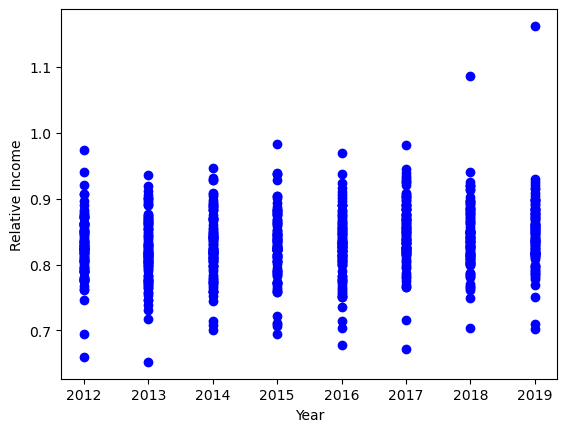

In [139]:
# let's visualize the first 100 data points of the set to get some intuition about it
for i in range(100):
    plt.scatter(years, relative_income[i], color='blue')

plt.xlabel('Year')
plt.ylabel('Relative Income')
plt.show()

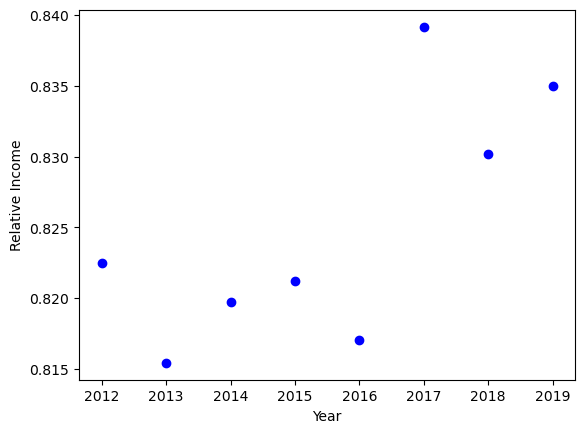

In [140]:
# in order to get one modell for all communities we can combine the data by for example taking the mean (which is a bit careless since not all communities are of the same size)
combined_income = np.mean(relative_income, axis=0)

# let's visualize the data now
plt.scatter(years, combined_income, color='blue')

plt.xlabel('Year')
plt.ylabel('Relative Income')
plt.show()

In [141]:
# let's split the data for the k-Fold cross validation to find the best degree for the polynomial regression
X_train, X_val, y_train, y_val = train_test_split(years, combined_income, test_size=0.2, random_state=42)

# let's choose a range of degree candidates
degree_candidates = range(1, 11)

# let's intialize variables for the best degree and the lowest error
best_degree = None
best_error = float('inf')

for degree in degree_candidates:
    # create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_train = poly_features.fit_transform(X_train.reshape(-1, 1))

    model = LinearRegression()

    # let's do a k-fold cross validation and calculate the mean squared error
    cv_scores = -cross_val_score(model, X_poly_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # calculate the average cross validation error
    avg_error = np.mean(cv_scores)

    # update the best degree, if the we find a smaller error
    if avg_error < best_error:
        best_error = avg_error
        best_degree = degree

print(f'The best degree is: {best_degree}')

The best degree is: 2


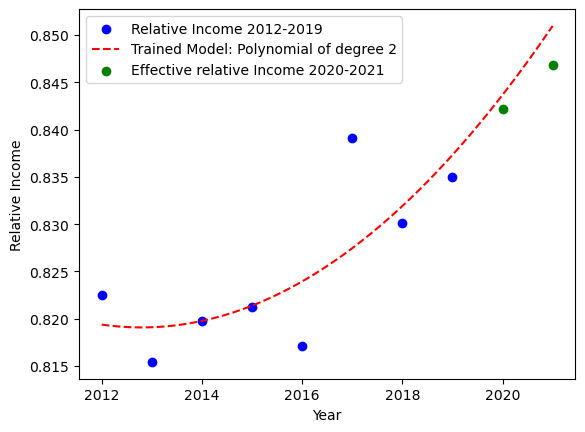

In [142]:
# now we found the best degree and we can start with the polynomial regression over the whole data of the years 2012-2019, afterwards we can evaluate the model with data from the years 2020 and 2021
degree = best_degree
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(years.reshape(-1, 1))

model_combined = LinearRegression()
model_combined.fit(X_poly, combined_income)

# prediction for the future years
future_years = np.array(prediction_year).reshape(-1, 1)
future_years_poly = poly_features.transform(future_years)
future_years_y = model_combined.predict(future_years_poly)

# we can also get the effective values from the data set
combined_income_effective = np.mean(prediction_income, axis=0)


# let's generate x-values for the prediction, then create the polynomial features and do the prediction:
x_values = np.linspace(min(years), max(years)+2, 100)
x_values_poly = poly_features.transform(x_values.reshape(-1, 1))
y_values_pred = model_combined.predict(x_values_poly)

# visaualization
plt.scatter(years, combined_income, label='Relative Income 2012-2019', color='blue')
plt.plot(x_values, y_values_pred, label=f'Trained Model: Polynomial of degree {degree}', linestyle='--', color='red')
plt.scatter(prediction_year, combined_income_effective, label='Effective relative Income 2020-2021', color='green')

plt.xlabel('Year')
plt.ylabel('Relative Income')
plt.legend()
plt.show()

In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#print(combined_income_effective)
#print(future_years_y)

# calculate the mean squared error (MSE)
mse = mean_squared_error(combined_income_effective, future_years_y)
print(f'MSE for the years 2020 and 2021: {mse}')

# calculate the R²-value
r2_value = r2_score(combined_income_effective, future_years_y)
print(f'R²-value for the years 2020 and 2021: {r2_value}')

MSE for the years 2020 and 2021: 9.548693951251095e-06
R²-value for the years 2020 and 2021: -0.7450833917833399


*Evaluation of the Modell and the Prediction*

Overall, our model appears to make accurate predictions for the test data (years 2020 and 2021) based on the low Mean Squared Error (MSE). However, it is always crucial to consider the results in context and, if possible, utilize various metrics for a more comprehensive evaluation of model performance. This becomes evident when looking at the R²-value, which appears far from promising.